<a href="https://colab.research.google.com/github/2024acheong/fintech-experiments/blob/main/portfolio_risk_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Risk Forecasting

Goal: Predict the risk of a portfolio (or individual asset) based on historical price data and macroeconomic indicators. This specific model will predict the volaality of the S&P 500

# Introduction

## 📉 What Is Volatility?

**Volatility** measures how much an asset’s price fluctuates over time.  
It is commonly calculated as the **standard deviation of returns** — higher volatility means more unpredictable price movements.

For example, if SPY’s daily returns bounce between -3% and +3%, it’s more volatile than a stock that stays between -0.5% and +0.5%.

---

## 💼 Why Volatility Matters in a Portfolio

### 🔹 1. Risk Assessment
Volatility is a key measure of **market risk**.  
Higher volatility = greater uncertainty = more potential for loss.

### 🔹 2. Portfolio Construction
Investors use volatility to **balance risk and return**.  
By diversifying across assets with different volatilities, the overall portfolio risk can be reduced.

### 🔹 3. Value at Risk (VaR) and Stress Testing
Many institutional risk metrics (like **VaR** and **Expected Shortfall**) rely on volatility forecasts.  
Accurate volatility modeling is essential for anticipating downside risk.

### 🔹 4. Risk-Based Position Sizing
Some strategies size positions based on asset volatility.  
Higher volatility may lead to smaller positions to avoid excessive risk.

---

> ⚠️ **Note:** Volatility reflects the *magnitude* of movement, not the *direction*.  
A volatile asset may swing sharply up or down — meaning big gains or big losses.

---

**TL;DR**:  
Volatility helps quantify **how risky** an asset or portfolio is.  
Forecasting it is essential for smarter investing, portfolio optimization, and financial risk management.


# Setup

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
# Pulling Historical Stock Data
tickers = ['SPY', 'QQQ', 'IWM']
data = yf.download(tickers, start='2010-01-01', end='2024-01-01', group_by='ticker')
print(data.columns)
data

/tmp/ipython-input-3-149590405.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2010-01-01', end='2024-01-01', group_by='ticker')
[*********************100%***********************]  3 of 3 completed

MultiIndex([('QQQ',   'Open'),
            ('QQQ',   'High'),
            ('QQQ',    'Low'),
            ('QQQ',  'Close'),
            ('QQQ', 'Volume'),
            ('SPY',   'Open'),
            ('SPY',   'High'),
            ('SPY',    'Low'),
            ('SPY',  'Close'),
            ('SPY', 'Volume'),
            ('IWM',   'Open'),
            ('IWM',   'High'),
            ('IWM',    'Low'),
            ('IWM',  'Close'),
            ('IWM', 'Volume')],
           names=['Ticker', 'Price'])


Ticker             QQQ                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2010-01-04   40.361992   40.501381   40.309720   40.440395  62822800   
2010-01-05   40.414261   40.510092   40.213889   40.440395  62935600   
2010-01-06   40.422982   40.553658   40.135489   40.196472  96033000   
2010-01-07   40.257447   40.309720   40.004803   40.222599  77094100   
2010-01-08   40.135478   40.553646   40.013513   40.553646  88886600   
...                ...         ...         ...         ...       ...   
2023-12-22  405.309805  406.271055  402.812553  404.695404  34292400   
2023-12-26  405.557523  407.846678  405.458419  407.172821  22722500   
2023-12-27  407.456366  408.289222  406.593737  408.001678  31980500   
2023-12-28  409.161784  409.409659  407.446481  407.803406  27029200   
2023-12-29  407.783560  408.140516  404.115003  406.038513  42633400   

Ticker             SPY                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2010-01-04   84.791237   85.560897   84.142305   85.515625  118944600   
2010-01-05   85.462824   85.779743   85.153447   85.742012  111579900   
2010-01-06   85.658990   86.013640   85.591081   85.802361  116074400   
2010-01-07   85.643902   86.270198   85.402439   86.164558  131091100   
2010-01-08   85.938185   86.489025   85.764637   86.451294  126402800   
...                ...         ...         ...         ...        ...   
2023-12-22  465.080521  466.572378  462.960567  464.874420   67126600   
2023-12-26  465.286659  467.750134  465.208124  466.837372   55387000   
2023-12-27  466.631275  467.828672  466.091477  467.681458   68000300   
2023-12-28  468.044575  468.702145  467.436067  467.858093   77158100   
2023-12-29  467.661823  468.191827  464.530923  466.503693  122234100   

Ticker             IWM                                                
Price             Open        High         Low       Close    Volume  
Date                                                                  
2010-01-04   51.218557   51.825508   51.202371   51.776951  42863900  
2010-01-05   51.696010   51.938790   51.380397   51.598896  55523100  
2010-01-06   51.598904   51.874055   51.420867   51.550350  59708600  
2010-01-07   51.582716   51.971164   51.097154   51.930698  56123500  
2010-01-08   51.744585   52.213959   51.631288   52.213959  48811500  
...                ...         ...         ...         ...       ...  
2023-12-22  197.553652  199.451686  196.875075  198.143707  39156100  
2023-12-26  198.861634  201.172711  198.350240  200.720337  26879000  
2023-12-27  201.054709  202.087325  200.031921  201.428421  35806400  
2023-12-28  200.415456  201.772609  199.913906  200.661316  28930100  
2023-12-29  200.110596  200.651491  197.386475  197.386475  41475800  

[3522 rows x 15 columns]

# Feature Engineering

In [ ]:
# Feature Engineering
close_prices = data.xs('Close', axis=1, level='Price')
close_prices
returns = close_prices.pct_change().dropna()

In [ ]:
features = pd.DataFrame(index=returns.index)
# Calculating 21 day rolling volatility, returns, moving averages, momentum
for ticker in tickers:
    features[f'{ticker}_ret'] = returns[ticker]
    features[f'{ticker}_vol_21'] = returns[ticker].rolling(21).std().shift(1)
    features[f'{ticker}_ma_7'] = returns[ticker].rolling(7).mean().shift(1)
    features[f'{ticker}_ma_21'] = returns[ticker].rolling(21).mean().shift(1)
    features[f'{ticker}_momentum_5'] = close_prices[ticker].pct_change(5).shift(1)

    mean = returns[ticker].rolling(21).mean()
    std = returns[ticker].rolling(21).std()
    features[f'{ticker}_zscore'] = ((returns[ticker] - mean) / std).shift(1)

# Add calendar features
features['day_of_week'] = features.index.dayofweek
features['month'] = features.index.month

# Drop missing values
features = features.dropna()
features

,SPY_ret,SPY_vol_21,SPY_ma_7,SPY_ma_21,SPY_momentum_5,SPY_zscore,QQQ_ret,QQQ_vol_21,QQQ_ma_7,QQQ_ma_21,QQQ_momentum_5,QQQ_zscore,IWM_ret,IWM_vol_21,IWM_ma_7,IWM_ma_21,IWM_momentum_5,IWM_zscore,day_of_week,month
Date,,,,,,,,,,,,,,,,,,,,
2010-02-04,-0.030866,0.010349,0.000128,-0.001442,0.000000,-0.342167,-0.028936,0.012472,-0.001270,-0.002591,-0.018121,0.648522,-0.033399,0.011402,-0.001607,-0.002144,-0.012290,-0.396720,3,2
2010-02-05,0.002067,0.012119,-0.003683,-0.003037,-0.019619,-2.296212,0.008447,0.013709,-0.005532,-0.003968,-0.021355,-1.821297,0.003896,0.013290,-0.004969,-0.003571,-0.028628,-2.244342,4,2
2010-02-08,-0.007219,0.012144,-0.004067,-0.002972,-0.006797,0.414957,-0.007213,0.013962,-0.005453,-0.003279,0.004441,0.839903,-0.009955,0.013380,-0.005930,-0.003341,-0.013974,0.540856,0,2
2010-02-09,0.012560,0.012061,-0.003459,-0.003517,-0.029066,-0.306905,0.010312,0.013956,-0.002808,-0.003653,-0.013638,-0.255057,0.013804,0.013219,-0.004903,-0.004166,-0.035186,-0.437898,1,2
2010-02-10,-0.001959,0.012484,-0.000112,-0.003078,-0.028628,1.252623,-0.002088,0.014052,0.001158,-0.003554,-0.012371,0.986776,0.002354,0.013642,-0.001356,-0.003769,-0.032526,1.288145,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.002010,0.005823,0.003241,0.002210,0.005522,1.248781,0.001496,0.007082,0.003553,0.002431,0.012877,1.299814,0.009318,0.013605,0.010066,0.006001,0.008263,0.809690,4,12
2023-12-26,0.004223,0.005811,0.001558,0.002122,0.009205,-0.019285,0.006122,0.007074,0.001950,0.002307,0.009512,-0.114645,0.013004,0.013624,0.006562,0.006146,0.026282,0.232825,1,12
2023-12-27,0.001808,0.005818,0.001702,0.002294,0.007797,0.331577,0.002036,0.007067,0.002948,0.002666,0.009335,0.489047,0.003528,0.013706,0.004444,0.006444,0.039259,0.478595,2,12


# Test/Train Setup

In [ ]:
target = returns['SPY'].rolling(21).std().shift(-1)
target = target.reindex(features.index)
# Combine X and y, and drop rows with NaNs in either
data = features.copy()
data['target'] = target
data = data.dropna()

X = data.drop(columns=['target'])
y = data['target']

In [ ]:
# Train test split (80/20)
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Model

In [ ]:
# Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(f"Test MSE: {mse:.6f}")

Test MSE: 0.000001


# Results

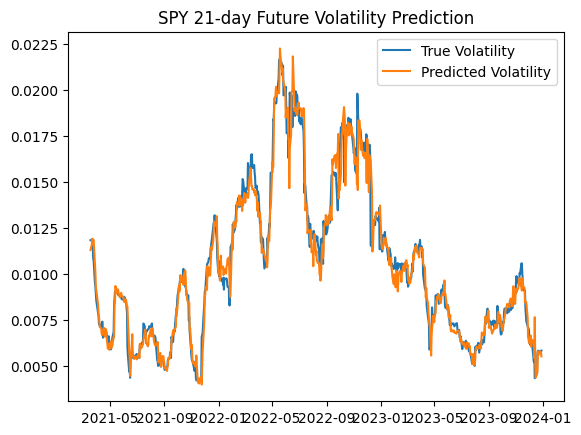

In [ ]:
plt.plot(y_test.index, y_test, label='True Volatility')
plt.plot(y_test.index, preds, label='Predicted Volatility')
plt.title("SPY 21-day Future Volatility Prediction")
plt.legend()
plt.show()

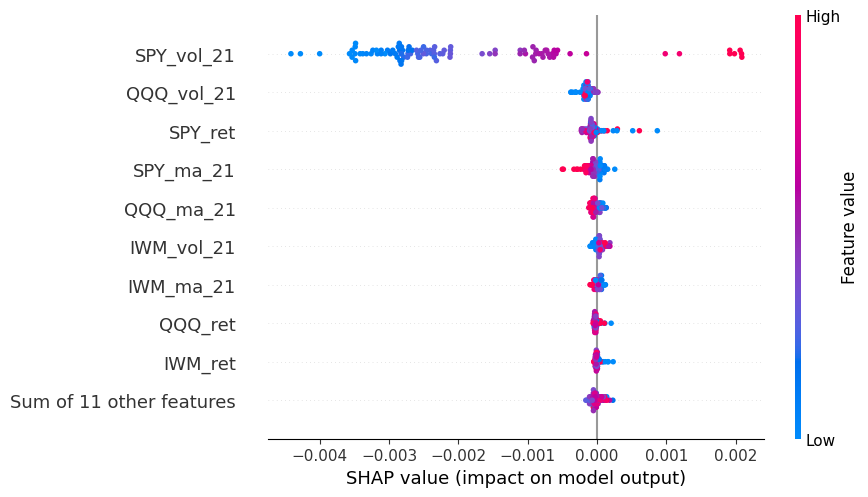

In [ ]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test[:100])

shap.plots.beeswarm(shap_values)

## 📊 Model Interpretation with SHAP

To better understand how the model forecasts future volatility, I applied **SHAP (SHapley Additive exPlanations)** to interpret feature contributions.

### 🔍 Key Insights

- **`SPY_vol_21`** (SPY's 21-day historical volatility) was the most influential feature.  
  → Higher recent volatility led to higher predicted future volatility — consistent with the well-known phenomenon of **volatility clustering** in financial markets.

- **`QQQ_vol_21`** and **`IWM_vol_21`** also contributed significantly, indicating that volatility in correlated ETFs provides useful **cross-asset signals** for predicting SPY risk.

- **`SPY_ret`**, **`QQQ_ret`**, and **`IWM_ret`** showed varied impact. Both large positive and negative recent returns influenced future volatility, capturing potential **market shocks or momentum bursts**.

- **21-day and 7-day moving averages** (`*_ma_21`, `*_ma_7`) for SPY, QQQ, and IWM had a moderate effect, helping the model detect **trend persistence or reversals**.

### ✅ Conclusion

The SHAP analysis confirms that the model learns intuitive financial patterns — relying heavily on recent and cross-asset volatility while incorporating trend and return-based signals. This makes the forecasts both **accurate and explainable**, a critical quality for real-world financial risk modeling.
